[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai2es/WAF_ML_Tutorial_Part1/blob/main/MOOC_Notebooks/Notebook02_Feature_Engineering.ipynb)

# Notebook 02: Feature Engineering [MOOC Colab Version]

Authors: Randy J. Chase, David R. Harrison, Amanda Burke, Gary M. Lackmann, and Amy McGovern<br>
Institution: [AI2ES](https://www.ai2es.org)<br>
Associated paper: [A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning](https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml)<br>
Original Github: [WAF_ML_Tutorial_Part1](https://github.com/ai2es/WAF_ML_Tutorial_Part1)

If you use this code or data in your work, please cite the paper: 

Chase, R. J., Harrison, D. R., Burke, A., Lackmann, G. M., & McGovern, A. (2022). A Machine Learning Tutorial for Operational Meteorology. Part I: Traditional Machine Learning, Weather and Forecasting, 37(8), 1509-1529.

### Goal: Understand how and why feature engineering was done on the SEVIR dataset

#### Background

In the last notebook, we showed you some example images of storms in the SEVIR dataset. While some ML approaches are to give ML models every bit of data, meaning we could potentially pass every single pixel in as a predictor, this would be overwhelmingly large (589824 total pixels for just 1 the visible image). So in this notebook we will show you how to engineer some statistics from each image. 


#### Reminder of Problem Statement

Before we jump into feature engineering (i.e., calculating statistics for each example), I want to remind you of the ML task we want to accomplish in the paper. 

1. Does this image contain a thunderstorm?
2. How many lightning flashes are in this image?

These will be important to consider when choosing the exact values we calculate from the images. Just to be clear, we will assume that we do not have the GOES Lightning Mapper to give us lighting. Instead we will aim to predict what the GOES lightning mapper would measure. While this might not seem initially useful, we could potentially create a climatology of lightning as measured from GOES prior to GOES-16 (i.e., November 2016). Another potential use would be to train a similar model without the radar data, and then use the resulting model on the MODIS sensor, which has been collecting global measurements since 1999 on the NASA TERRA mission. The default images [here](https://worldview.earthdata.nasa.gov/) are MODIS, imagine if we could have lightning flashes with these obs? 

#### Step 0: Get the github repo (we need some of the functions there)

The first step with all of these Google Colab notebooks will be to grab the github repo and cd into the notebooks directory. 

To run things from the command line, put a ```!``` before your code



In [1]:
#get the github repo 
!git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1.git 

#cd into the repo so the paths work 
import os 
os.chdir('/content/WAF_ML_Tutorial_Part1/jupyter_notebooks/')

Cloning into 'WAF_ML_Tutorial_Part1'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 301 (delta 139), reused 236 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 195.77 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (100/100), done.


#### Step 1: Import packages and load data.  
This is basically the same first two steps as the last notebook.


In [2]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import plot_feature_loc

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#open an example storm 
ds = xr.open_dataset('../datasets/sevir/onestorm.nc')

For fun, lets actually calculate how many pixels are in this dataset. So without re-gridding the number of pixels are: 

In [3]:
print('{} pixels'.format(ds.x.shape[0]**2 + ds.x2.shape[0]**2 + ds.x3.shape[0]**2 + ds.x4.shape[0]**2))

776448 pixels


In other words we would have three quarters of 1 million predictors. Which is far too many. Hopefully this illustrates why we choose to extract some statistics from each variable and use those instead.

#### Step 2: Choose Percentiles

While it might be tempting to run with just a single metric from each image, e.g., the mean value, let's think about the data meteorologically.

1. What do the data tell us about the storms?
    - Visible reflectance is larger with thicker storms (i.e., deeper storms)
    - Visible reflectance is low with the surface 
    - Water vapor brightness temperature is low with thicker storms, colder surface temperatures 
    - Water vapor brightness temperature is larger with thinner storms, larger surface temperatures 
    - Clean IR channel is similar to Water Vapor
    - Vertically integrated liquid is larger with stronger updrafts 
    
Based on this list of 'interpreting' the data and understanding that in general storms are more likely to contain lightning if they are taller and more intense suggests that we need a range of percentiles, depending on what variable is used. To make things easy, we just calculate all the same percentiles for each image. We choose the [min,1,10,25,median,75,90,99,max] to encompass each one of the above listed storm properties.

In python, the min is the 0th percentile, the median is also the 50th percentile and the max is the 100th percentile. Let's define the desired percentiles here

In [4]:
desired_percentiles = np.array([0,1,10,25,50,75,90,99,100])

#### Step 3: Calculate percentiles one 1 image

We will now show how the percentiles are calculated for 1 visible image

In [5]:
#select the first time step (ds_sub means subset of the dataset)
ds_sub = ds.isel(t=0)
#isolate just the visible image (da means DataArray), dont forget the scaling!
da = ds_sub.visible*1e-4
da

<xarray.DataArray 'visible' (x: 768, y: 768)>
array([[0.0242    , 0.024     , 0.0226    , ..., 0.056     , 0.0605    ,
        0.1021    ],
       [0.0229    , 0.023     , 0.0228    , ..., 0.09119999, 0.0451    ,
        0.0404    ],
       [0.0236    , 0.0231    , 0.0228    , ..., 0.15179999, 0.0881    ,
        0.0429    ],
       ...,
       [0.0297    , 0.0283    , 0.028     , ..., 0.4782    , 0.4736    ,
        0.48209998],
       [0.0297    , 0.0286    , 0.0289    , ..., 0.479     , 0.4768    ,
        0.4827    ],
       [0.0299    , 0.0302    , 0.0303    , ..., 0.48189998, 0.48079997,
        0.48569998]], dtype=float32)
Dimensions without coordinates: x, y

numpy has a built in function that will help use calculate the percentiles named nanpercentile

In [6]:
percentiles = np.nanpercentile(da.values,desired_percentiles,axis=(0,1))
percentiles

array([0.0132    , 0.0215    , 0.0325    , 0.0423    , 0.1962    ,
       0.47499999, 0.55979997, 0.68379998, 1.02189994])

#### Step 4: Double check

It is helpful to make sure the calculated statistics make sense on where they come from in the image. So lets visualize it

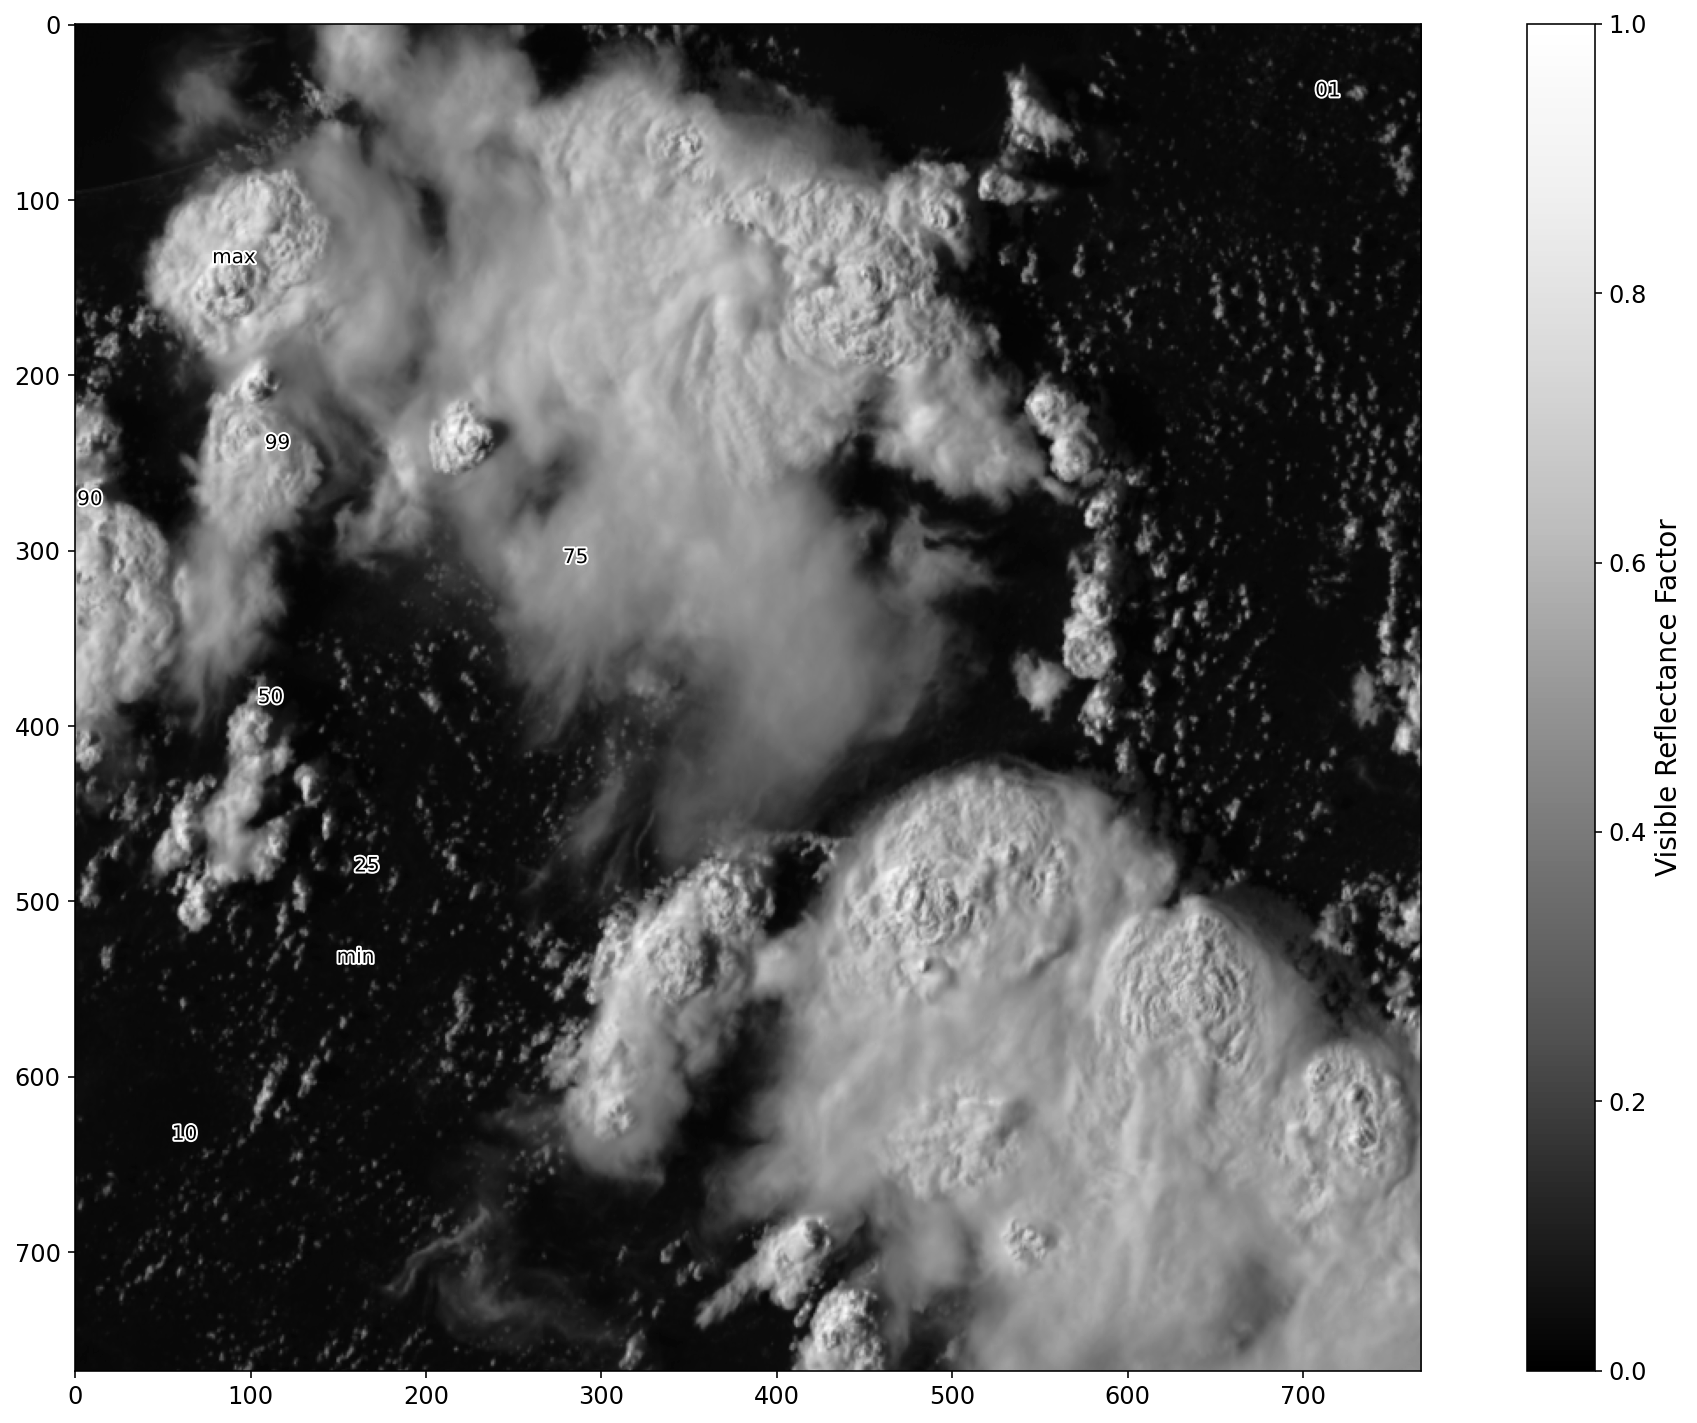

In [7]:
#make a figure with size 15 inches in the x, and 10 inches in the y
plt.figure(figsize=(15,10))
#show all x pixels (:) and all y pixels (:) and the first time step, with a Grey colorscale, and the color min 0 and color max 1. 
plt.imshow(da,cmap='Greys_r',vmin=0,vmax=1)

#a more advanced plotting function. Dont get bogged down in the details if you dont want
plot_feature_loc(da,plt.gca())

#show us the colorbar 
plt.colorbar(label='Visible Reflectance Factor')
#a function that cleans some of the figure up. 
plt.tight_layout()

At this point you should take a step back and make sure the locations plotted above make sense. Does the ```min``` show up in a dark spot? Does the ```max``` should up in a bright spot? 

Please know that there are alot of pixels in this image. So each percentile likely has more than 1 location in the image. So each time you run the code the labels will be probably in a new spot.

#### Step 5: Run the percentile calculation across more than 1 image 

This step is actually quite tricky to do in an efficient manner since we have > 10,000 events each with 49 time steps. For the interested party, please see the scripts titled ```Process_SEVIR.py``` and ```processing_SEVIR_functions.py```

#### Step 6: Look at the results: 

After processing your dataset it is always good to give it a look over and make sure there are no spurious data points. Let's take a gander at the Water Vapor file. 

All processed files are can be found in the ```datasets``` folder. Each variable gets its own comma separated value (csv) file. The individual files are meant to keep any individual file from becoming > 100 mb. The first column is the datetime, then the next 9 each correspond to the percentiles labeled with ```q_``` and then the number is the percentile, then the last column is a storm report inside the image. 

We will use [pandas](https://pandas.pydata.org/), an awesome tool for tabular data to load our csv file

In [8]:
import pandas as pd 

#read csv wants the data path, and we tell it the index is the time, which makes slicing easier later.
df = pd.read_csv('../datasets/sevir/WV_stats_master.csv',index_col=0,low_memory=False)
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-6149.0,-6037.00,-5853.0,-5707.00,-5498.0,-5306.0,-4997.0,-3637.63,-3325.0,NaN
2018-03-22 14:15:00,-6167.0,-6032.00,-5847.0,-5710.00,-5499.0,-5295.0,-4989.0,-3695.63,-3295.0,NaN
2018-03-22 14:20:00,-6188.0,-6030.37,-5846.0,-5711.25,-5499.0,-5268.0,-4949.3,-3742.00,-3346.0,NaN
2018-03-22 14:25:00,-6191.0,-6025.00,-5848.0,-5712.00,-5498.0,-5246.0,-4894.0,-3751.63,-3358.0,NaN
2018-03-22 14:30:00,-6201.0,-6018.00,-5840.0,-5716.00,-5506.0,-5234.0,-4833.0,-3711.63,-3415.0,NaN


Looking at the first 5 data points, you can see that the numbers look too big to be brightness temperatures (in degC). Thats because there is the scalar offset for this variable as well. This time the authors multiplied by 100, so we need to multiply the percentiles by 10^-2. 

In [9]:
#we dont want to multiply the 'event' column
keys = list(df.keys()[:-1])
df[keys] = df[keys]*1e-2
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-61.49,-60.3700,-58.53,-57.0700,-54.98,-53.06,-49.970,-36.3763,-33.25,NaN
2018-03-22 14:15:00,-61.67,-60.3200,-58.47,-57.1000,-54.99,-52.95,-49.890,-36.9563,-32.95,NaN
2018-03-22 14:20:00,-61.88,-60.3037,-58.46,-57.1125,-54.99,-52.68,-49.493,-37.4200,-33.46,NaN
2018-03-22 14:25:00,-61.91,-60.2500,-58.48,-57.1200,-54.98,-52.46,-48.940,-37.5163,-33.58,NaN
2018-03-22 14:30:00,-62.01,-60.1800,-58.40,-57.1600,-55.06,-52.34,-48.330,-37.1163,-34.15,NaN


Ah much better. Pandas has some cool built in functions. For example, we can use ```.describe``` to see some summary statistics of each column

In [10]:
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000,618992.000000
mean,-57.094519,-52.226658,-46.171140,-41.440475,-35.875888,-31.186900,-28.204743,-25.287387,-23.898188
std,12.577898,12.062988,11.812426,11.176882,9.858604,8.323602,7.263426,6.273164,5.853209
min,-183.120000,-81.920000,-77.410000,-73.440000,-71.030000,-68.260000,-67.280000,-64.530000,-60.540000
25%,-66.890000,-61.490000,-54.960000,-49.530000,-42.070000,-35.420000,-32.153000,-29.140000,-27.690000
50%,-57.760000,-53.293700,-46.610000,-40.720000,-34.250000,-30.160000,-27.570000,-24.900000,-23.620000
75%,-49.350000,-44.450000,-37.280000,-32.740000,-28.860000,-25.580000,-23.360000,-21.050000,-19.920000
max,-11.980000,-11.630000,-10.330000,-8.600000,-7.460000,-5.950000,-5.050000,-3.910000,22.870000


This is helpful in seeing the distribution of each percentile and checking for spurious data. For example, look at the ```min``` row, there is an outlier, 
the minimum Tb of q0000 is -183, which is 100 degrees lower than the minimum q001, lets get rid of that erroneous point

In [11]:
df = df.where(df.q000 > -100)
df.describe()

,q000,q001,q010,q025,q050,q075,q090,q099,q100
count,618991.000000,618991.000000,618991.000000,618991.000000,618991.000000,618991.000000,618991.00000,618991.000000,618991.000000
mean,-57.094315,-52.226642,-46.171117,-41.440452,-35.875863,-31.186876,-28.20472,-25.287367,-23.898263
std,12.576888,12.062991,11.812422,11.176875,9.858592,8.323587,7.26341,6.273151,5.852912
min,-90.990000,-81.920000,-77.410000,-73.440000,-71.030000,-68.260000,-67.28000,-64.530000,-60.540000
25%,-66.890000,-61.490000,-54.960000,-49.530000,-42.070000,-35.420000,-32.15300,-29.140000,-27.690000
50%,-57.760000,-53.293700,-46.610000,-40.720000,-34.250000,-30.160000,-27.57000,-24.900000,-23.620000
75%,-49.350000,-44.450000,-37.280000,-32.740000,-28.860000,-25.580000,-23.36000,-21.050000,-19.920000
max,-11.980000,-11.630000,-10.330000,-8.600000,-7.460000,-5.950000,-5.05000,-3.910000,12.390000


While tables are great, I am a visual learning, so lets look at these distributions in histogram form 

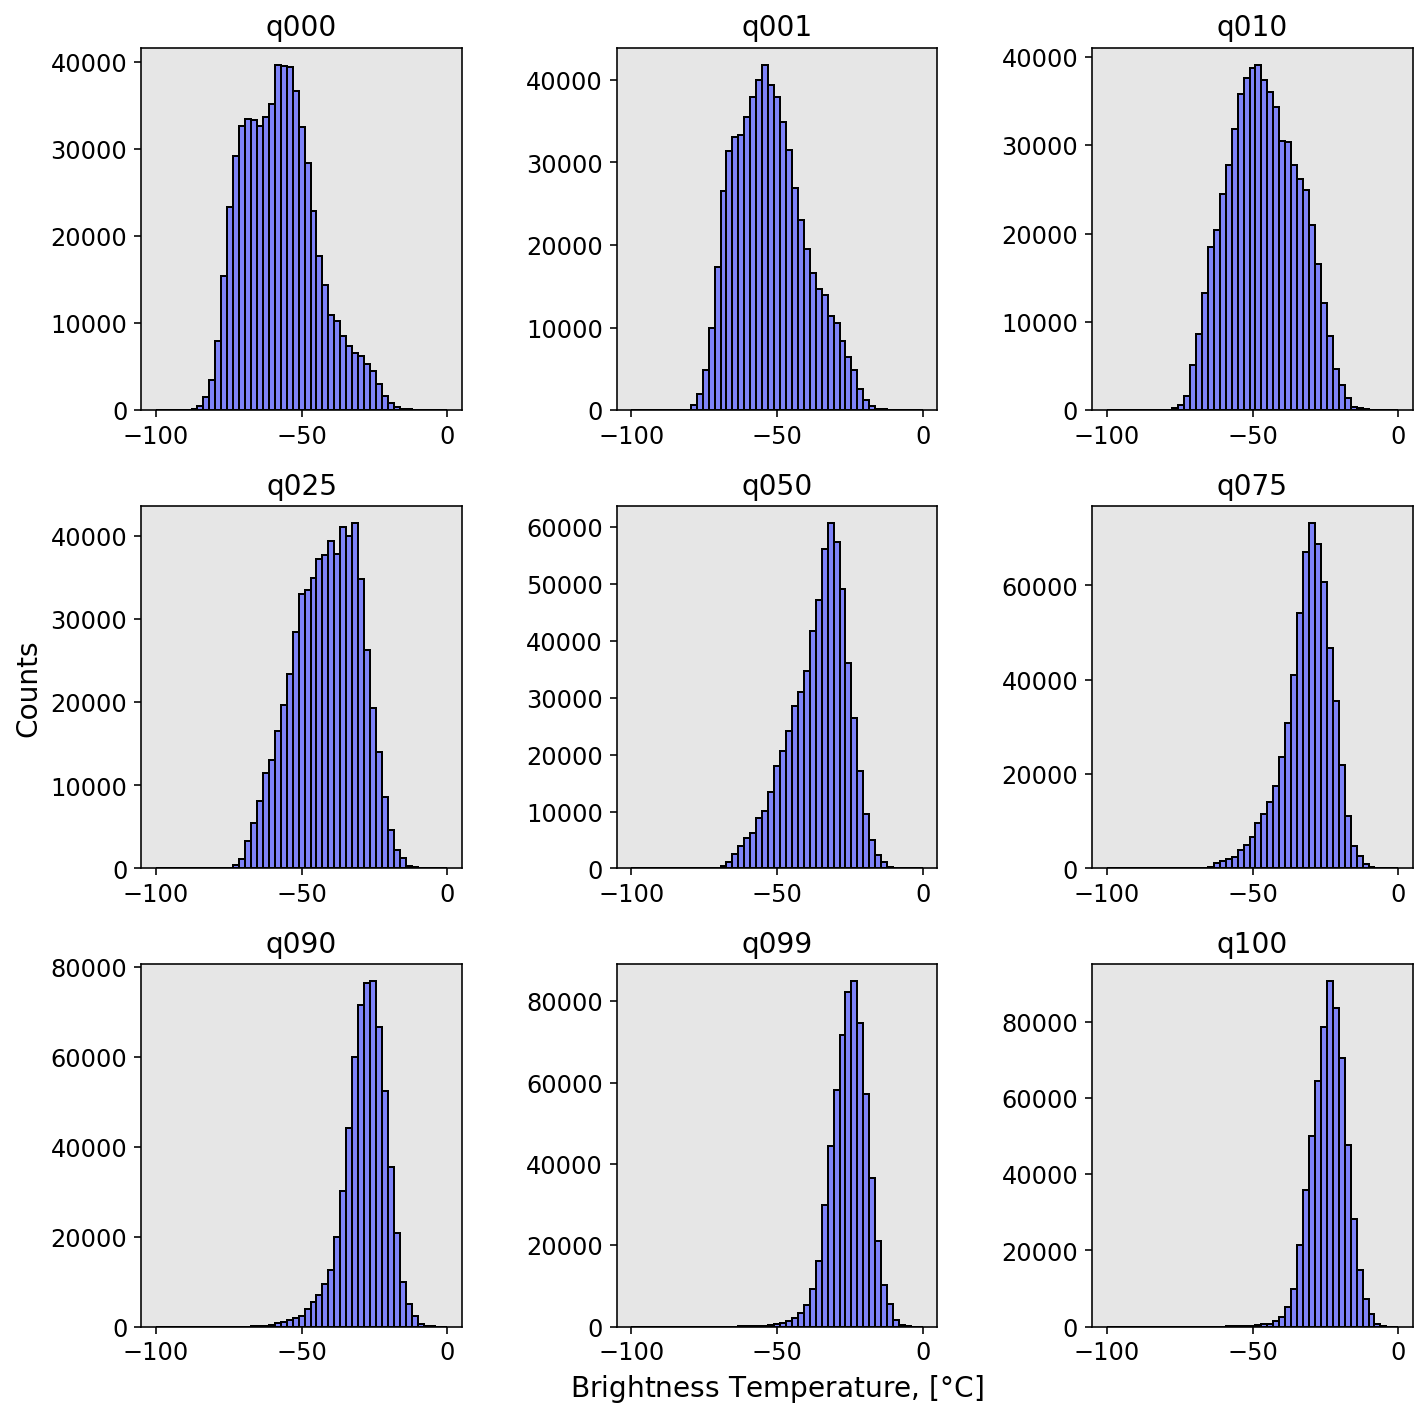

In [12]:
#make the bins, 50 of them, evenly spaced from -100 degC to 0 degC
bins=np.linspace(-100,0)
#a nice color 
b = [126/255,131/255,248/255]

#make a big plot with 9 subplots 
fig,axes = plt.subplots(3,3,figsize=(10,10))

#ravel axes 
axes = axes.ravel()

#loop over all variables to make things more concise. enumerate makes an iterable and returns a counter (i) and the axis in axes.  
for i,ax in enumerate(axes):
    key = keys[i]
    ax.hist(df[key],bins=bins,color=b,edgecolor='k')
    ax.set_title(key)
    
#add some axis labels
axes[3].set_ylabel('Counts')
axes[7].set_xlabel('Brightness Temperature, [$\degree$C]')
    
plt.tight_layout()

For practice, I encourage you to do this type of analysis with the other variables (i.e., features). Once you do that, go ahead a proceed on to Notebook 3 where we will go through splitting up the data into the ```train```, ```validation``` and ```test``` sets. 

In [13]:
#read csv wants the data path, and we tell it the index is the time, which makes slicing easier later.
df = pd.read_csv('../datasets/sevir/IR_stats_master.csv',index_col=0,low_memory=False)
df.head()

,q000,q001,q010,q025,q050,q075,q090,q099,q100,event
2018-03-22 14:10:00,-6026.0,-5908.0,-5699.0,-5511.0,-5234.0,-4994.0,-4493.0,-1931.26,-470.0,NaN
2018-03-22 14:15:00,-6040.0,-5907.0,-5695.0,-5519.0,-5241.0,-4976.0,-4470.3,-2099.89,-859.0,NaN
2018-03-22 14:20:00,-6062.0,-5911.0,-5696.0,-5522.0,-5242.0,-4947.0,-4400.0,-2319.52,-1063.0,NaN
2018-03-22 14:25:00,-6080.0,-5906.0,-5698.0,-5526.0,-5244.5,-4915.0,-4330.0,-2243.63,-891.0,NaN
2018-03-22 14:30:00,-6106.0,-5905.0,-5692.0,-5532.0,-5256.0,-4894.0,-4287.0,-2003.00,-885.0,NaN
